In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import collections
import math
import pandas as pd
import copy

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Unpack the dataset zip file
import shutil
shutil.unpack_archive("/content/drive/MyDrive/DeepLearning/Retinal OCT_M.zip","Dataset")

In [5]:
batch_size = 32
transform_train = transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    transforms.Resize((32,32)),
    #torchvision.transforms.RandomResizedCrop(32, scale=(0.08, 1.0),
    #                                         ratio=(3.0/4.0, 4.0/3.0)),
    #torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    #torchvision.transforms.ColorJitter(brightness=0.4,
    #                                   contrast=0.4,
    #                                   saturation=0.4),
    # Add random noise
    transforms.ToTensor(),
    # Standardize each channel of the image
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

transform_test = transforms.Compose([
    transforms.Resize((32,32)),
    # Crop a 224 x 224 square area from the center of the image
    #torchvision.transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
   ])

In [6]:
data_dir = '/content/Dataset/Retinal OCT Dataset (Original) - Copy'

train_ds, train_valid_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_train) for folder in ['train', 'train']]

valid_ds, test_ds = [datasets.ImageFolder(
    os.path.join(data_dir, folder),
    transform=transform_test) for folder in ['val', 'test']]

In [7]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [8]:
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_ds:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_ds)
stds /= len(train_ds)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([-1.2600, -1.1586, -0.9313])
Calculated stds: tensor([0.7650, 0.7821, 0.7786])


In [9]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

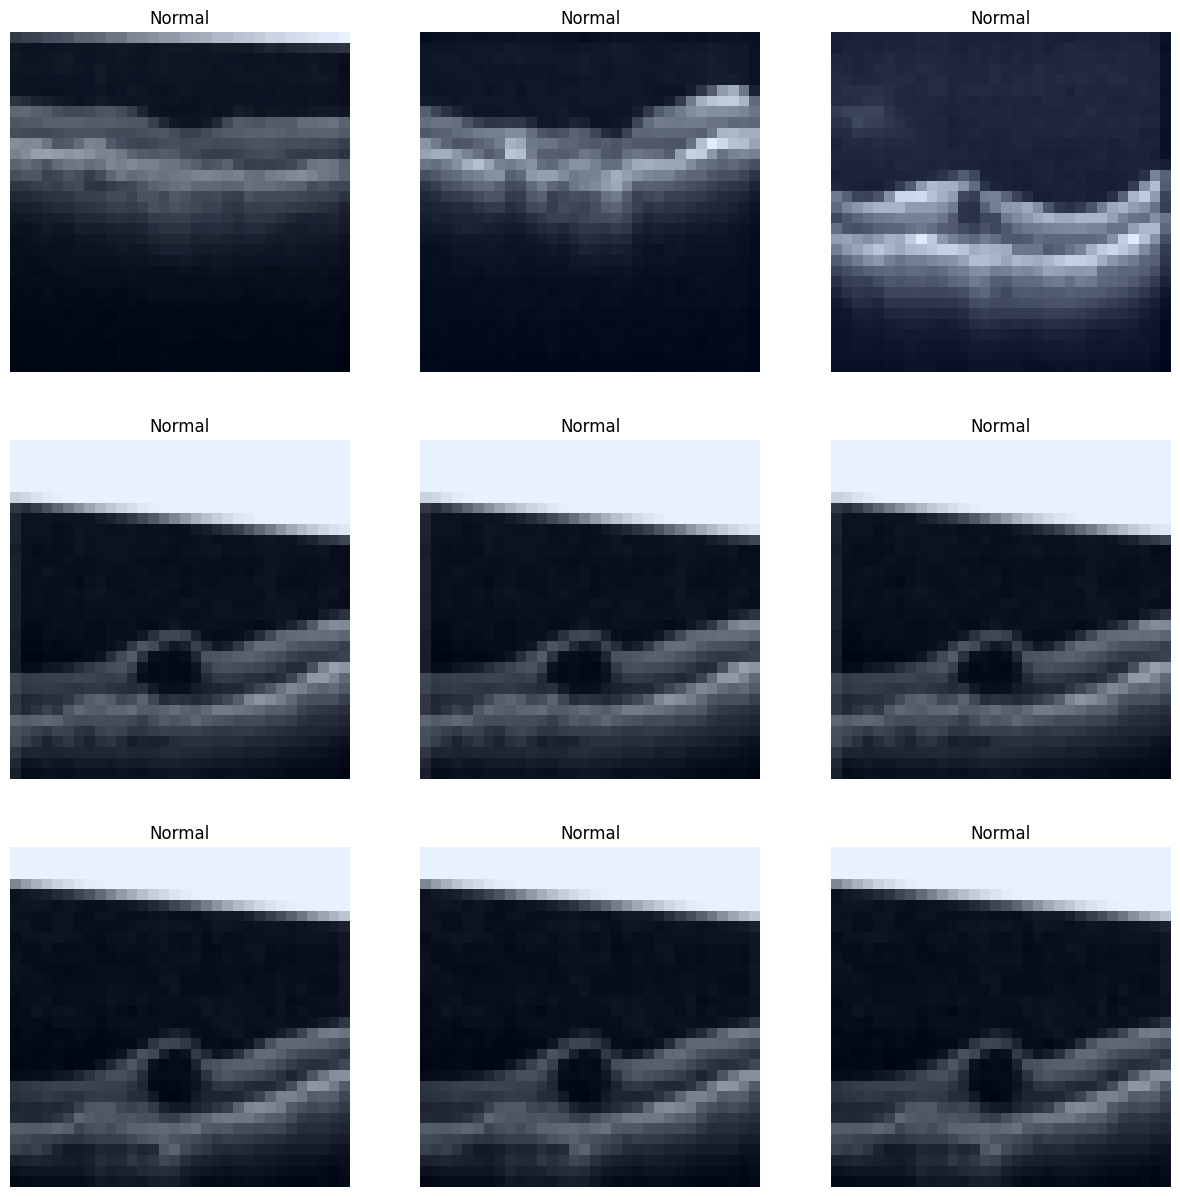

In [10]:
N_IMAGES = 10

images, labels = zip(*[(image, label) for image, label in 
                           [train_ds[i] for i in range(N_IMAGES)]])

classes = ['Normal', 'Drusen', 'DME', 'CNV']

plot_images(images, labels, classes)

In [11]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [12]:
#Changing the class no value

OUTPUT_DIM = 4

model = AlexNet(OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,247,684 trainable parameters


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=CHOSE_LR)

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [19]:
EPOCHS = 10 # You may need to run longer to get better results. Lab example is for demo only

# keeping-track-of-losses 
train_losses = []
valid_losses = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 41s
	Train Loss: 2.029 | Train Acc: 45.68%
	 Val. Loss: 1.344 |  Val. Acc: 50.00%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 42s
	Train Loss: 0.935 | Train Acc: 59.87%
	 Val. Loss: 1.040 |  Val. Acc: 56.25%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.849 | Train Acc: 64.21%
	 Val. Loss: 0.857 |  Val. Acc: 56.25%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 40s
	Train Loss: 0.750 | Train Acc: 68.65%
	 Val. Loss: 1.034 |  Val. Acc: 59.38%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.682 | Train Acc: 71.17%
	 Val. Loss: 0.812 |  Val. Acc: 75.00%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 39s
	Train Loss: 0.613 | Train Acc: 74.26%
	 Val. Loss: 0.729 |  Val. Acc: 75.00%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 40s
	Train Loss: 0.589 | Train Acc: 75.45%
	 Val. Loss: 0.661 |  Val. Acc: 71.88%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 40s
	Train Loss: 0.542 | Train Acc: 77.96%
	 Val. Loss: 0.864 |  Val. Acc: 68.75%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 38s
	Train Loss: 0.495 | Train Acc: 79.87%
	 Val. Loss: 0.789 |  Val. Acc: 71.88%


Training:   0%|          | 0/227 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 39s
	Train Loss: 0.472 | Train Acc: 79.83%
	 Val. Loss: 0.595 |  Val. Acc: 75.00%


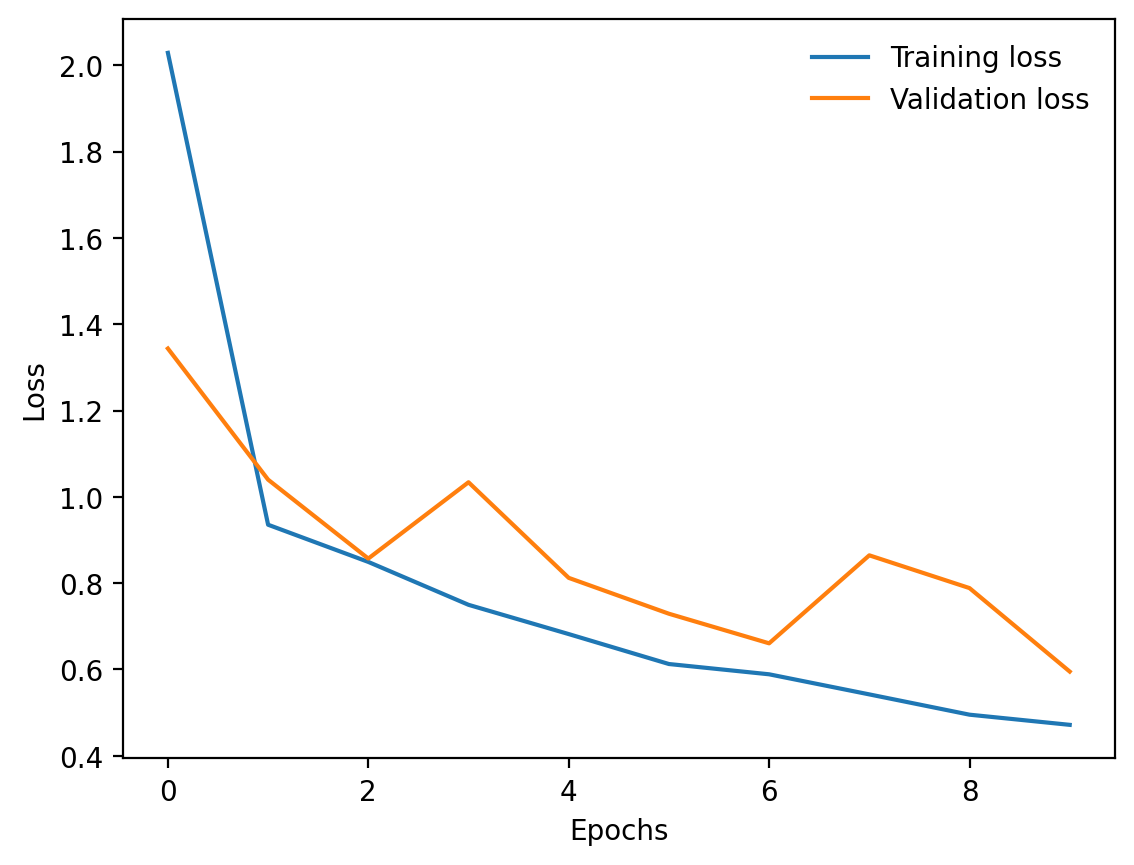

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [21]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [22]:
images, labels, probs = get_predictions(model, test_iter, device)

In [23]:
test = pd.read_csv('/content/drive/MyDrive/DeepLearning/Ground_Truth_Modified.csv', encoding='latin1')
y_test = np.array(test.drop(['Image'], axis=1))

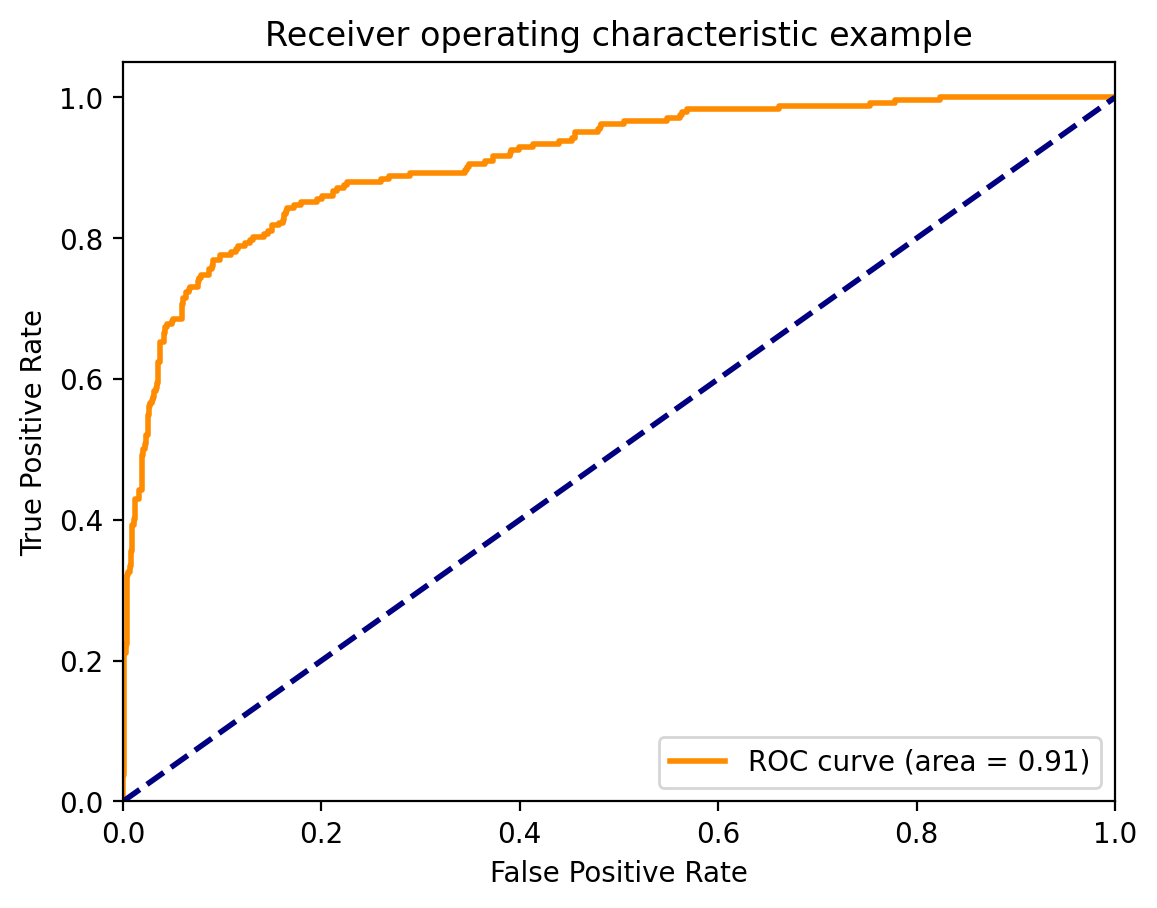

<ipython-input-24-9e52edd549f7>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


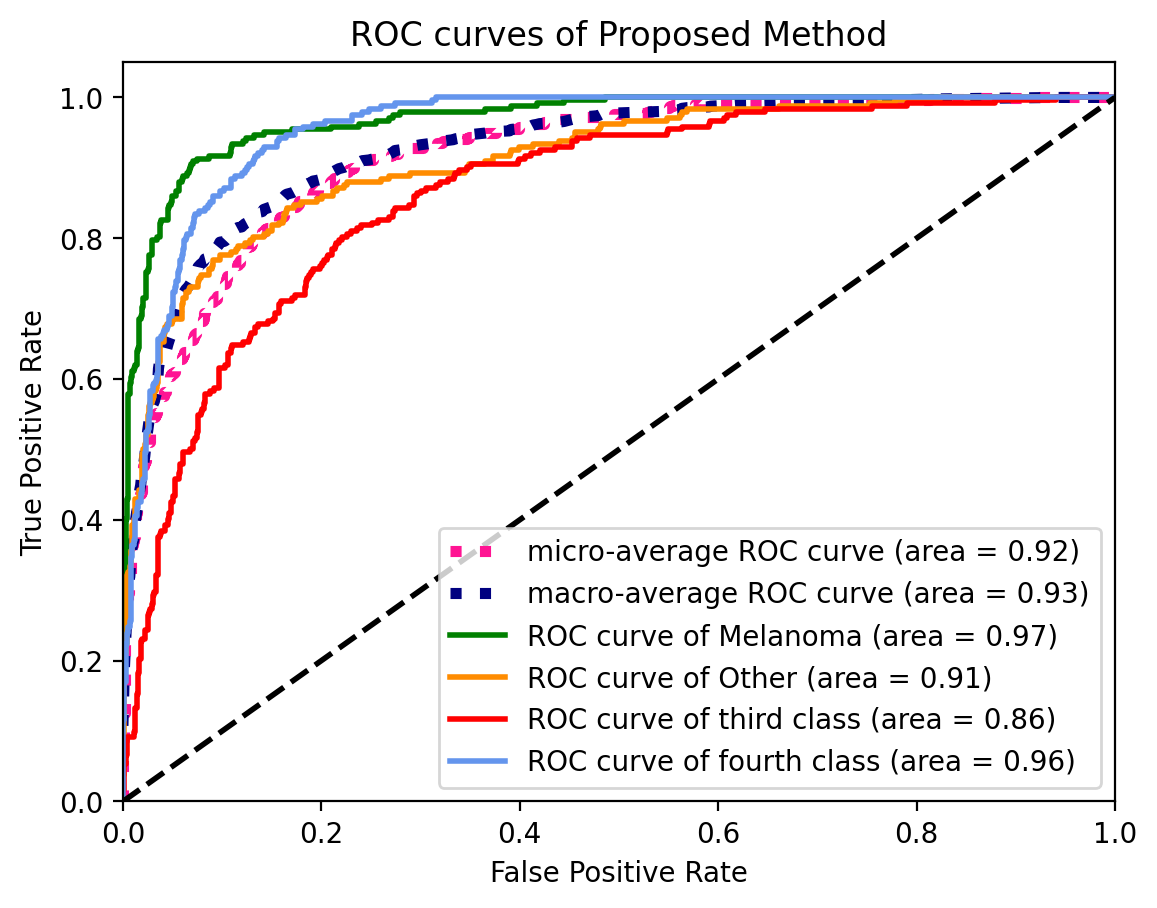

In [24]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
#change to OneVsOneClassifier for generalized AUC
#from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

n_classes=4

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
    
plt.plot(fpr[0], tpr[0], color='green', lw=lw,
         label='ROC curve of Melanoma (area = {1:0.2f})'
         ''.format(0, roc_auc[0]))

plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw,
         label='ROC curve of Other (area = {1:0.2f})'
         ''.format(1, roc_auc[1]))

# if you need more classes
plt.plot(fpr[2], tpr[2], color='red', lw=lw,
          label='ROC curve of third class (area = {1:0.2f})'
          ''.format(1, roc_auc[2]))

plt.plot(fpr[3], tpr[3], color='cornflowerblue', lw=lw,
          label='ROC curve of fourth class (area = {1:0.2f})'
          ''.format(1, roc_auc[3]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of Proposed Method')
plt.legend(loc="lower right")
plt.show()

[[217  18   5   2]
 [ 18 173  10  41]
 [ 33  30  68 111]
 [  0   4   3 235]]
[0 1 2 3]
[242 242 242 242]
[[242. 242. 242. 242.]
 [242. 242. 242. 242.]
 [242. 242. 242. 242.]
 [242. 242. 242. 242.]]


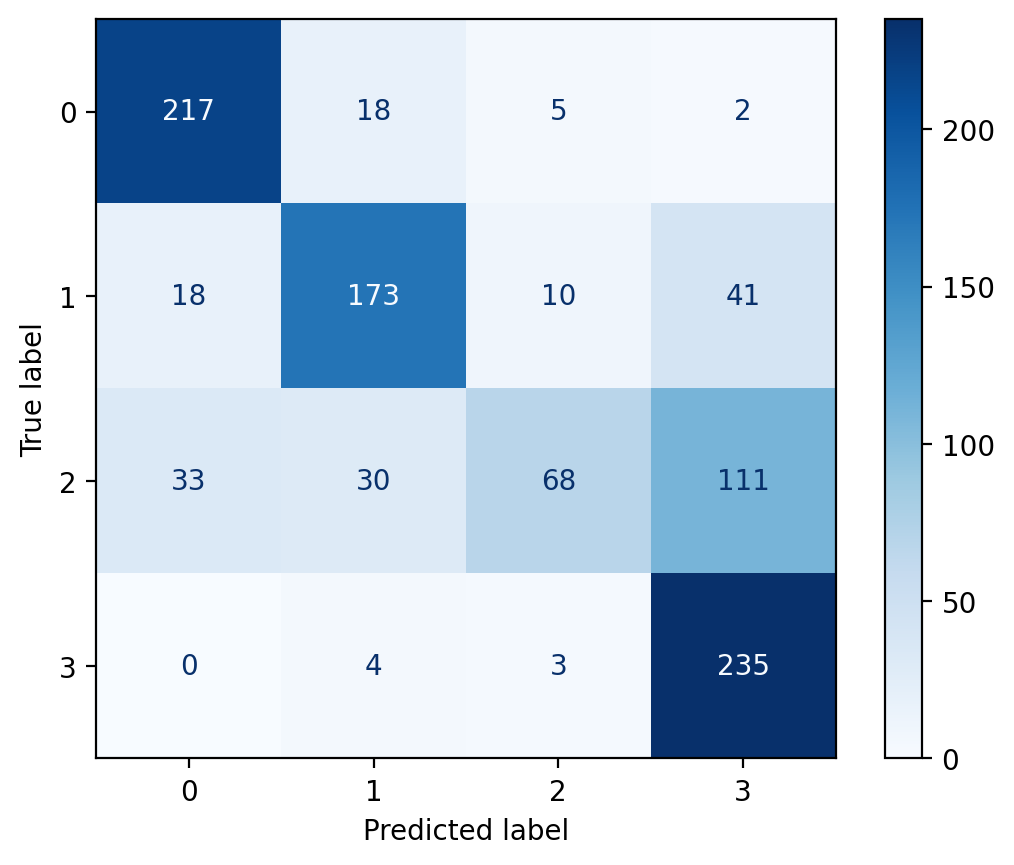

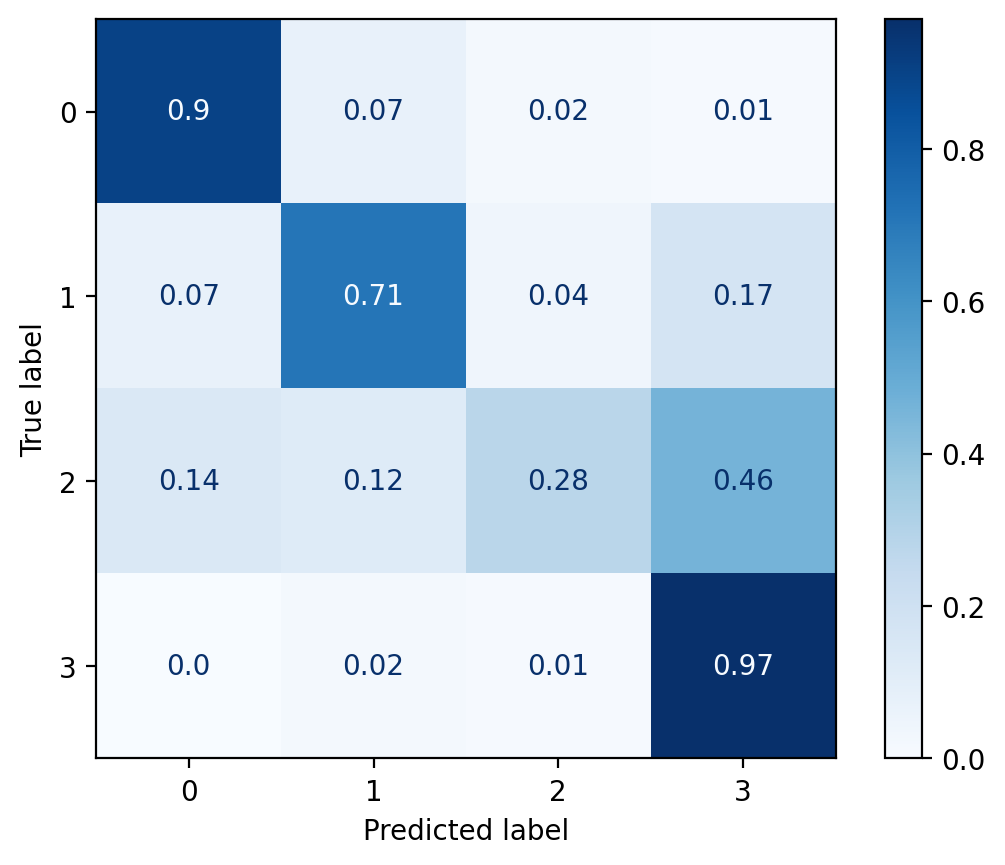

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from matplotlib.colors import Normalize
from sklearn.metrics import ConfusionMatrixDisplay

pred_class = np.argmax(probs,axis=1)
true_class = np.argmax(y_test, axis=1)

cm=confusion_matrix(true_class, pred_class)
class_names = unique_labels(true_class, pred_class)
print(cm)
print(class_names)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

C = cm
divisor = np.zeros((4,4))
divisor[0][:] = 242
divisor[1][:] = 242
divisor[2][:] = 242
divisor[3][:] = 242
cm_normalised=np.divide(cm, divisor)
print(np.transpose(C.sum(axis=1)))
print(divisor)
cm_normalised = np.round(cm_normalised, 2)
disp = ConfusionMatrixDisplay(cm_normalised, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='')

In [26]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

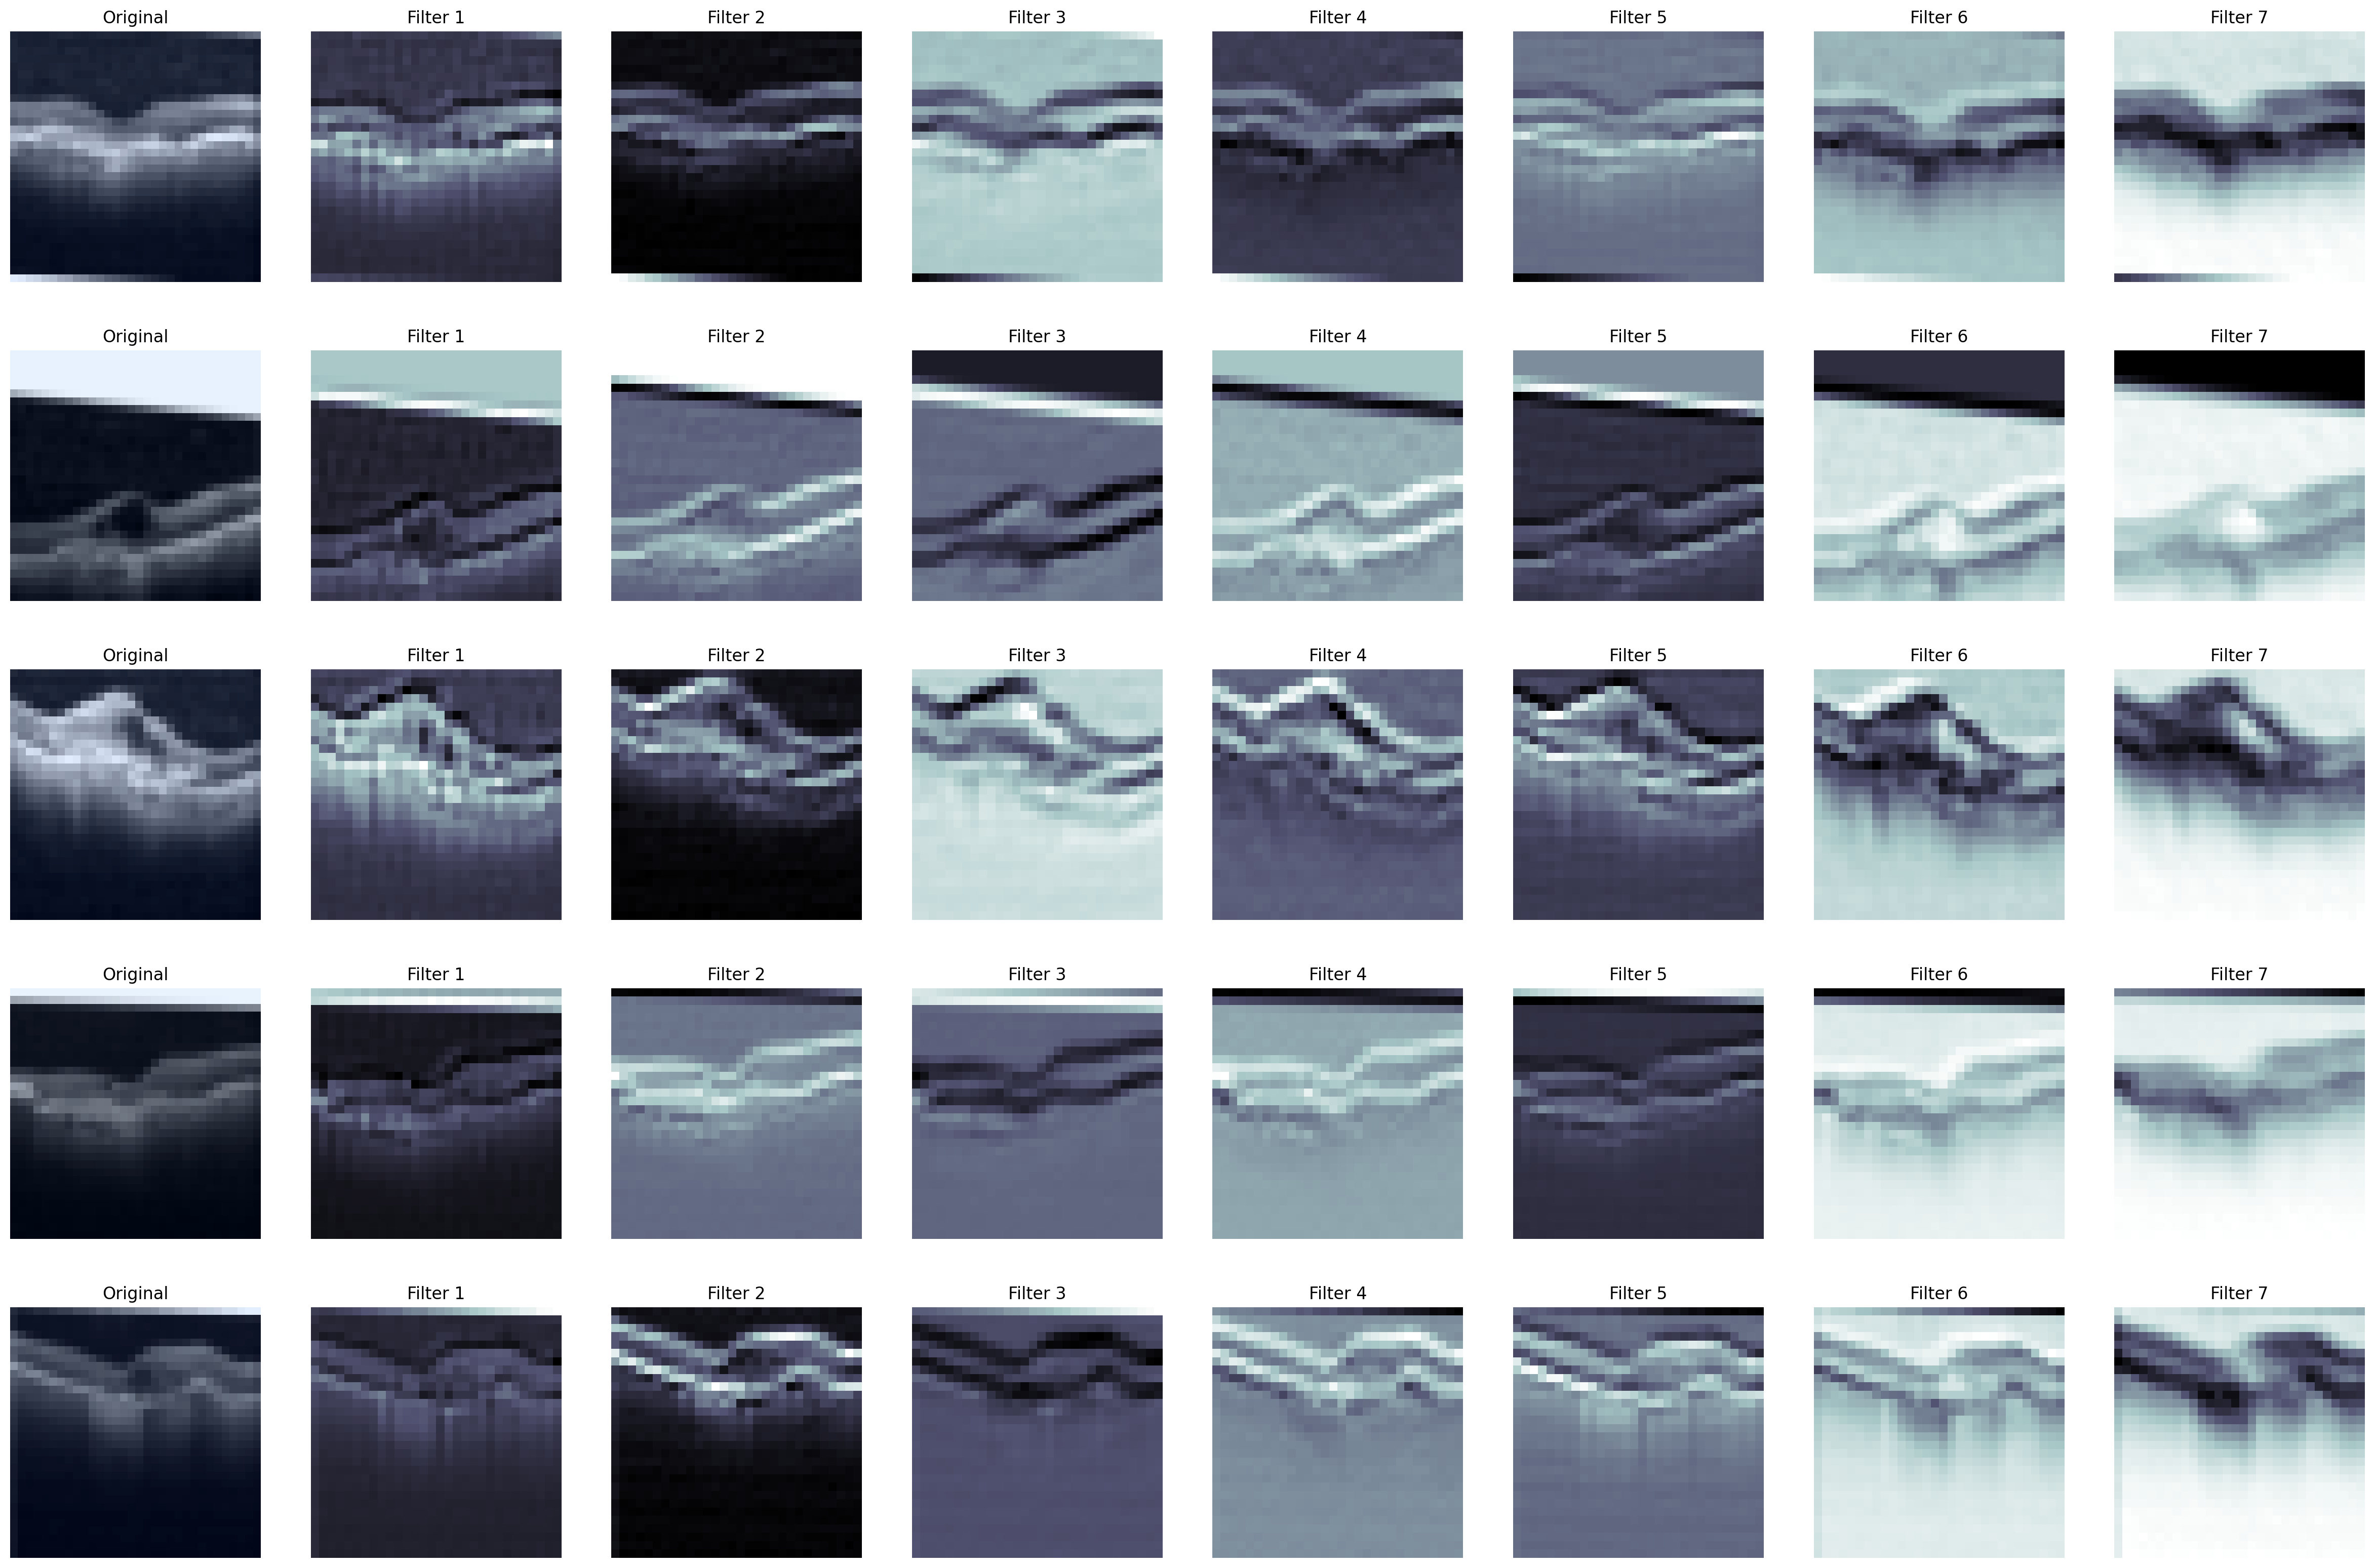

In [27]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_ds[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

In [28]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

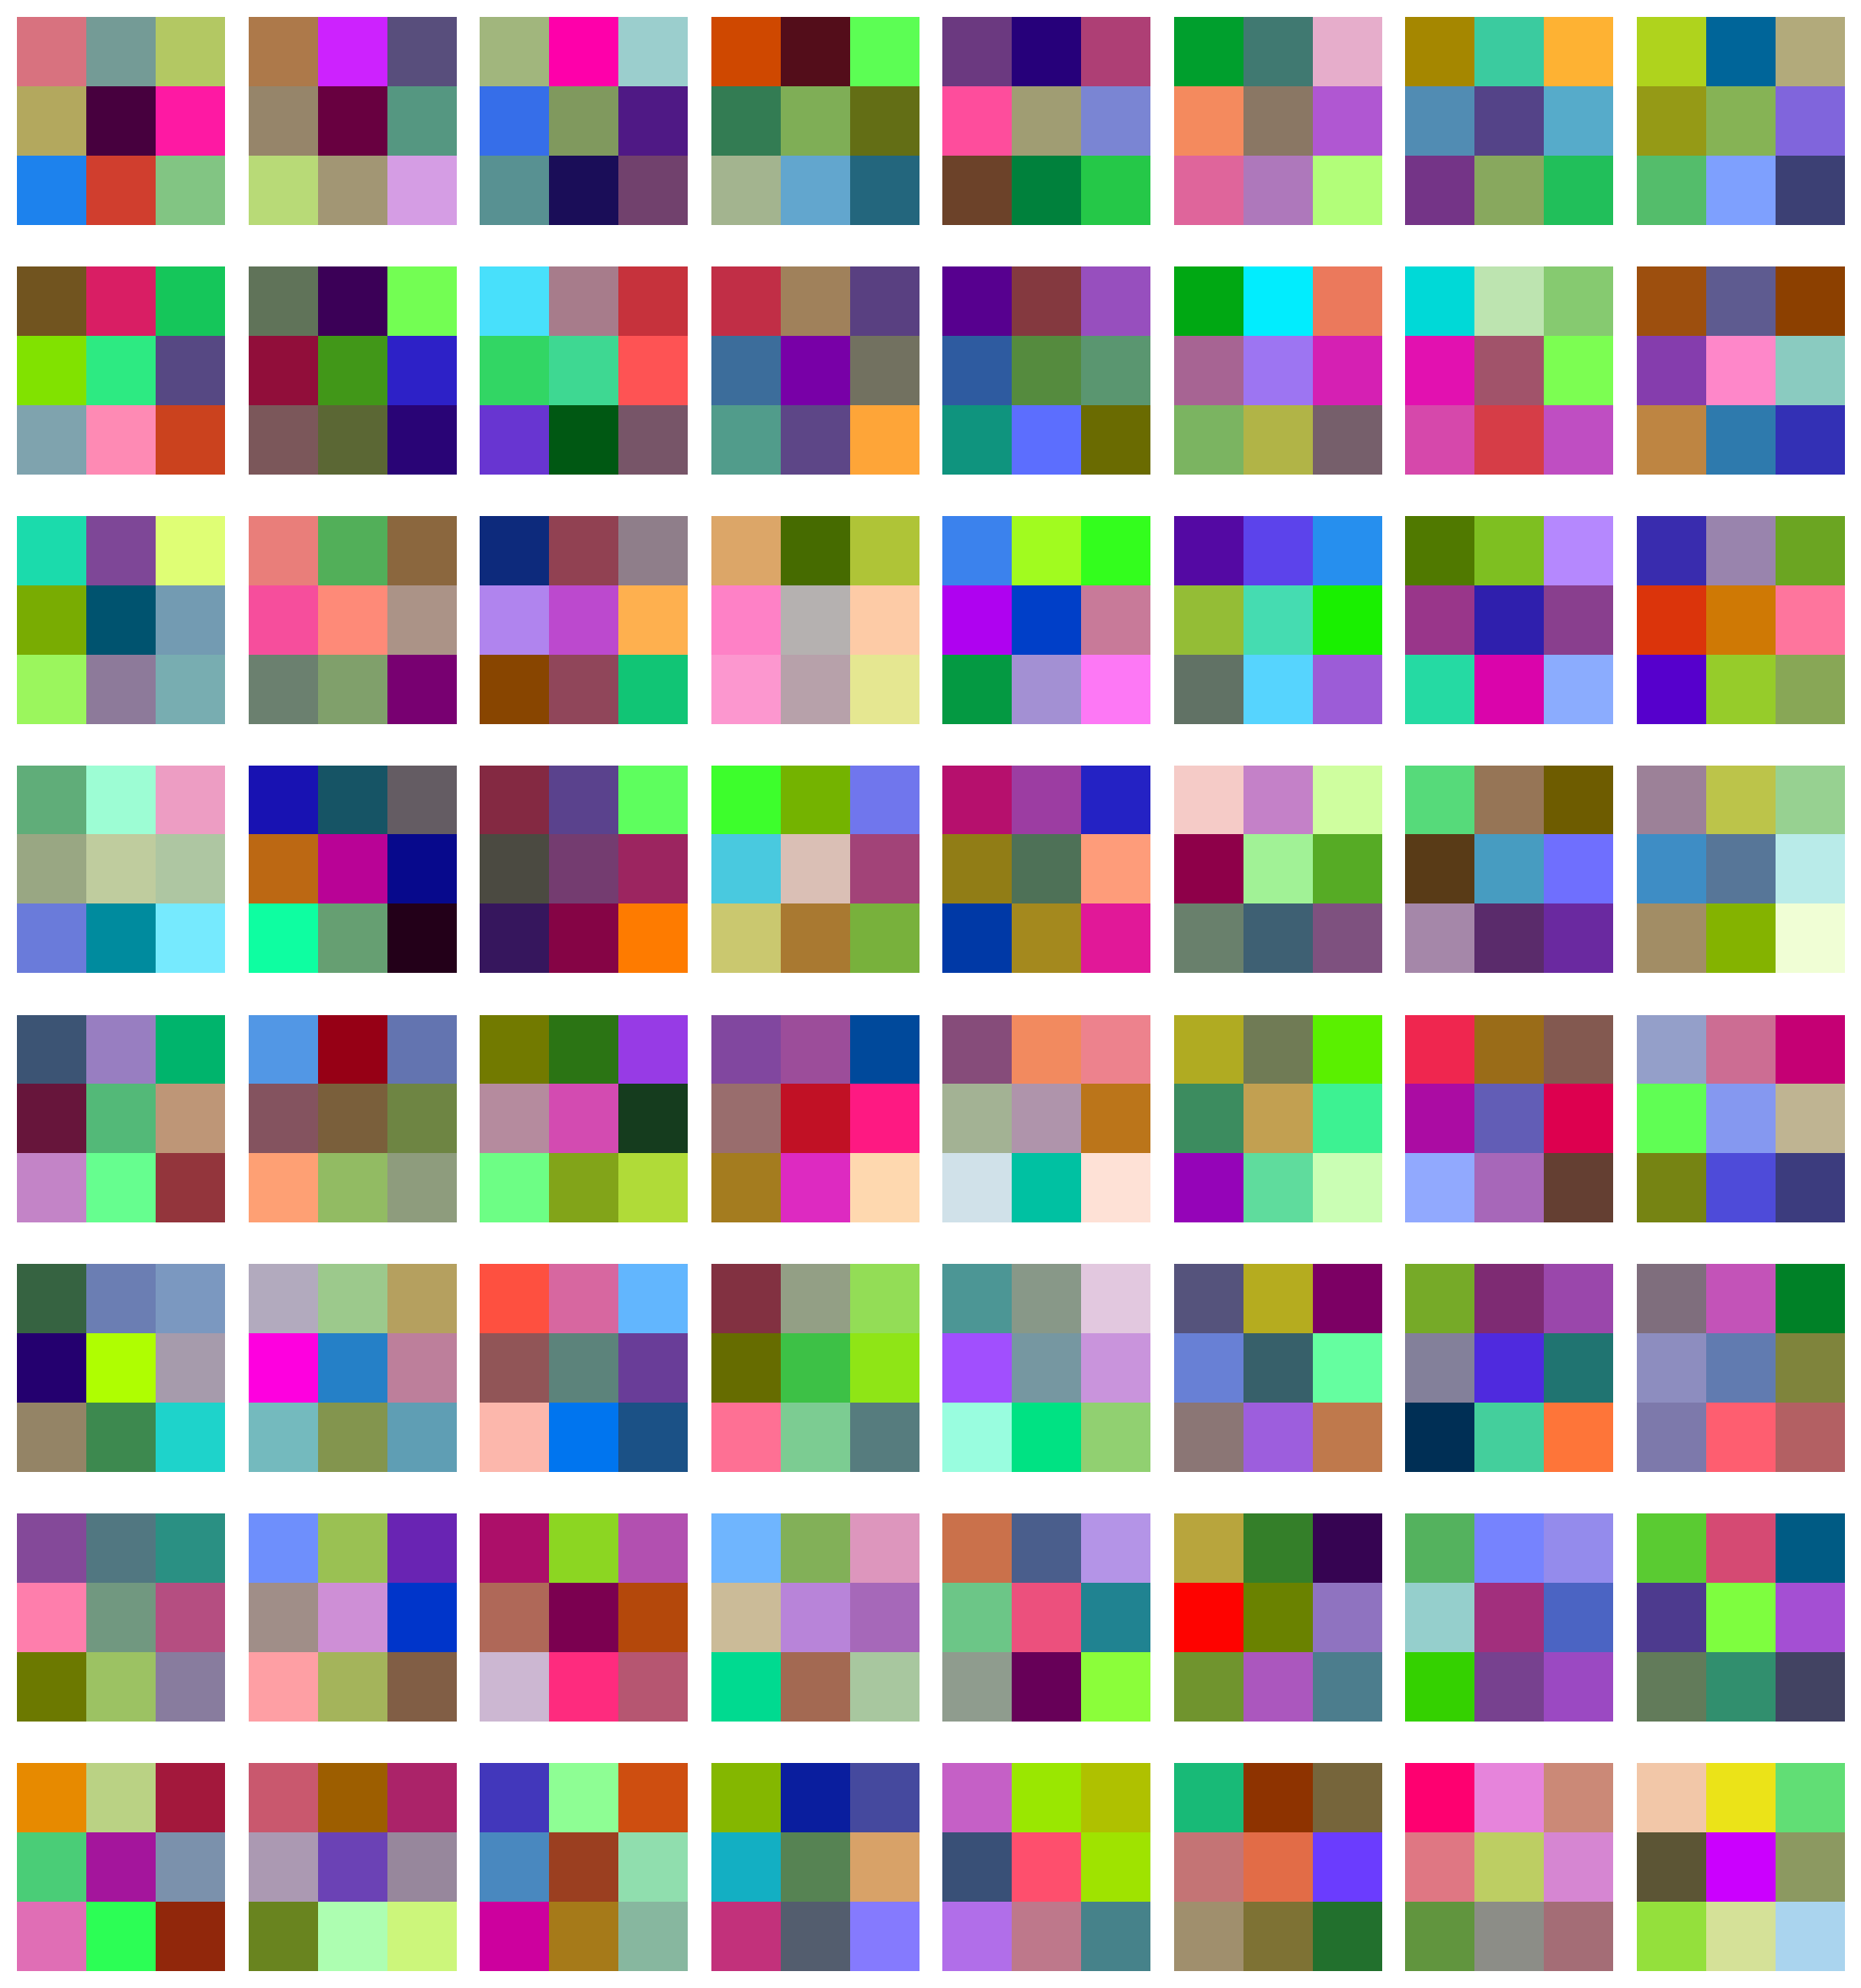

In [29]:
plot_filters(filters)

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

num_classes=4

# Convert probabilities to predicted labels
y_pred_labels = np.argmax(probs, axis=1)

# Convert predicted labels to multilabel-indicator format
y_pred_labels_multilabel = label_binarize(y_pred_labels, classes=np.arange(num_classes))

# Calculate precision
precision = precision_score(y_test, y_pred_labels_multilabel, average='macro') * 100

# Calculate recall
recall = recall_score(y_test, y_pred_labels_multilabel, average='macro') * 100

# Calculate confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred_labels_multilabel.argmax(axis=1))

# Calculate specificity
specificity = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) * 100

# Calculate F1-score
f1 = f1_score(y_test, y_pred_labels_multilabel, average='macro') * 100

# Print the calculated metrics
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("Specificity: {:.2f}%".format(specificity))
print("F1-score: {:.2f}%".format(f1))

Precision: 74.34%
Recall: 71.59%
Specificity: 92.34%
F1-score: 68.78%
